In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxa
from shapely import geometry
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

from phase_o_matic.download import download_era
from phase_o_matic.preprocess import get_vapor_partial_pressure, convert_pressure_to_pascals, interpolate_to_heights
from phase_o_matic.phase_delay import calculate_refractive_indexes

read ISCE geometry files: hgt/los/lat/lon.rdr
calculate tropospheric delay from GRB files...
------------------------------------------------
INFO: INCIDENCE ANGLE AS AN ARRAY
INFO: AREA COVERAGE IN SNWE: (33.85, 30.05, 129.05, 132.45)
PROGRESS: READING GRIB FILE
INFO: USING PRESSURE LEVELS OF ERA-INT OR ERA-5 DATA
INFO: IMAGE DIMENSIONS: 15 LATITUDES AND 13 LONGITUDES
3:Specific humidity:kg kg**-1 (instant):regular_ll:isobaricInhPa:level 1:fcst time 0 hrs:from 201010171400
6:Specific humidity:kg kg**-1 (instant):regular_ll:isobaricInhPa:level 2:fcst time 0 hrs:from 201010171400
9:Specific humidity:kg kg**-1 (instant):regular_ll:isobaricInhPa:level 3:fcst time 0 hrs:from 201010171400
12:Specific humidity:kg kg**-1 (instant):regular_ll:isobaricInhPa:level 5:fcst time 0 hrs:from 201010171400
15:Specific humidity:kg kg**-1 (instant):regular_ll:isobaricInhPa:level 7:fcst time 0 hrs:from 201010171400
18:Specific humidity:kg kg**-1 (instant):regular_ll:isobaricInhPa:level 10:fcst time 0 hrs:

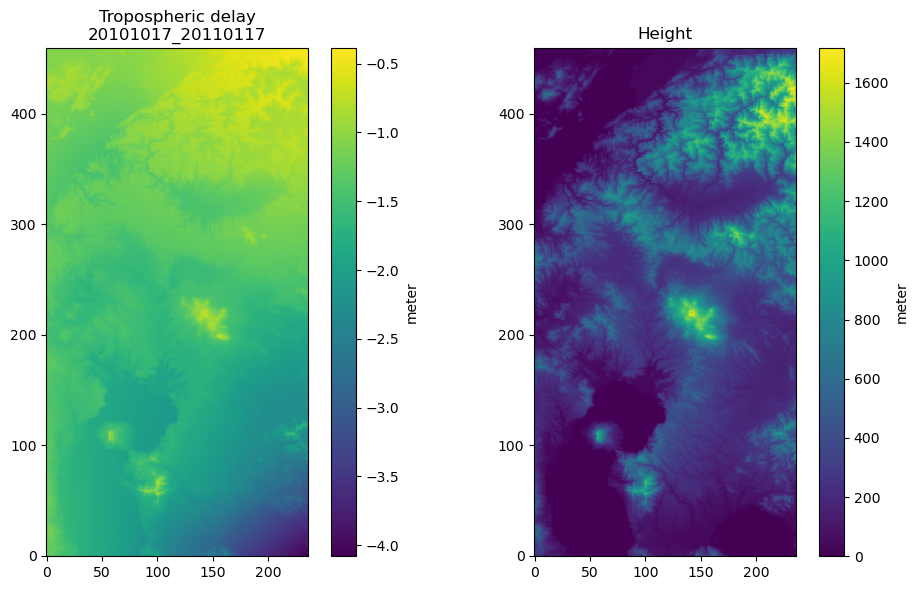

In [3]:
import pyaps3 as pa
import os
import matplotlib.pyplot as plt

data_dir = '/Users/zachkeskinen/Documents/phase-o-matic/PyAPS/tests/data'
# read geometry files
print('read ISCE geometry files: hgt/los/lat/lon.rdr')
dem = pa.utils.read_data(os.path.join(data_dir, 'hgt.rdr'))
inc = pa.utils.read_data(os.path.join(data_dir, 'los.rdr'), dname='inc')
lat = pa.utils.read_data(os.path.join(data_dir, 'lat.rdr'))
lon = pa.utils.read_data(os.path.join(data_dir, 'lon.rdr'))

# calculate
print('calculate tropospheric delay from GRB files...')
print('------------------------------------------------')
grb_file1 = os.path.join(data_dir, 'ERA5/ERA5_N30_N40_E120_E140_20101017_14.grb')
grb_file2 = os.path.join(data_dir, 'ERA5/ERA5_N30_N40_E120_E140_20110117_14.grb')
obj1 = pa.PyAPS(grb_file1, dem=dem, inc=inc, lat=lat, lon=lon, grib='ERA5', verb=True)
obj2 = pa.PyAPS(grb_file2, dem=dem, inc=inc, lat=lat, lon=lon, grib='ERA5', verb=True)
phs = obj2.getdelay(wvl = 0.238403545) - obj1.getdelay(wvl = 0.238403545)

# plot
date12 = '{}_{}'.format(grb_file1.split('_')[-2], grb_file2.split('_')[-2])
titles = [f'Tropospheric delay\n{date12}', 'Height']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[10, 6])
for ax, data, title in zip(axs, [phs, dem], titles):
    im = ax.imshow(data, interpolation='nearest')
    # axis format
    ax.invert_yaxis()
    ax.set_title(title)
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('meter')
fig.tight_layout()

print('------------------------------------------------')
print('Passed tropospheric delay calculation from ERA5.')
print('------------------------------------------------')
plt.show()

In [4]:
xr.DataArray(obj1.dem, coords = [obj1.lat[:,0], obj1.lon[0, :]], dims = ['latitude', 'longitude'])

<xarray.DataArray (latitude: 460, longitude: 237)>
array([[ 2.46379631e+02,  2.52680029e+02,  2.85904824e+02, ...,
        -1.88233406e-05, -1.88427983e-05, -1.88621884e-05],
       [ 2.79544354e+02,  2.57932940e+02,  2.75999599e+02, ...,
        -1.88200231e-05, -1.88394757e-05, -1.88588685e-05],
       [ 2.85963296e+02,  2.70012193e+02,  2.72641144e+02, ...,
        -1.88169428e-05, -1.88363496e-05, -1.88557959e-05],
       ...,
       [-1.31850346e-05, -1.32027577e-05, -1.32204665e-05, ...,
         4.32182861e+02,  3.72431075e+02,  3.06950256e+02],
       [-1.31822278e-05, -1.31999283e-05, -1.32176631e-05, ...,
         4.57456478e+02,  4.23748767e+02,  4.05155807e+02],
       [-1.31802444e-05, -1.31979208e-05, -1.32156827e-05, ...,
         4.35903135e+02,  4.39792729e+02,  4.71341873e+02]])
Coordinates:
  * latitude   (latitude) float64 31.25 31.26 31.26 31.26 ... 32.53 32.53 32.54
  * longitude  (longitude) float64 130.5 130.5 130.5 130.5 ... 131.2 131.3 131.3

In [5]:
# interpolate delays to uavsar
# SNWE: (33.85, 30.05, 129.05, 132.45)
# N30_N40_E120_E140
geom = geometry.box(129.05, 30.05, 132.45, 33.85)
time1 = pd.to_datetime('2010-10-17T14:00')
time2 = pd.to_datetime('2011-01-17T14:00')
time_DAs = []
max_alt = None
for time in [time1, time2]:
    fp = download_era(date = time, out_dir = '../data/', subset = geom, LOS = False, humid_param='specific_humidity')
    # fp = f"/Users/zachkeskinen/Documents/phase-o-matic/data/ERA5_{time.strftime('%Y-%m-%dT%H')}:00_-116.31_43.59_-114.90_44.46.nc"
    era = xr.open_dataset(fp) #'../data/ERA5_2021-01-15T12:00_-116.31_43.59_-114.90_44.46.nc'
    era = convert_pressure_to_pascals(era)
    era = get_vapor_partial_pressure(era)
    # max_alt = (geom['dem'] + np.abs(geom['lkv_z'])).max() if max_alt is None else max_alt
    ds = interpolate_to_heights(era, max_alt = 42000)
    ds = calculate_refractive_indexes(ds)
    # new stuff below
    # ds = ds.interp_like(geom, method = 'linear', kwargs={"fill_value": "extrapolate"})
    # ds = ds.interp(height = np.round(np.arange(geom['dem'].min()-2, geom['dem'].max()+2)), method = 'linear')
    time_DAs.append(ds)
ds = xr.concat(time_DAs, dim = 'time')

2023-05-08 13:54:29,626 INFO Welcome to the CDS
2023-05-08 13:54:29,627 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2023-05-08 13:54:30,062 INFO Request is completed
2023-05-08 13:54:30,063 INFO Downloading https://download-0012-clone.copernicus-climate.eu/cache-compute-0012/cache/data8/adaptor.mars.internal-1683353728.591823-20439-15-ff05e178-f662-4b58-a054-4e8507a6d917.nc to ../data/ERA5_2010-10-17T14:00_129.05_30.05_132.45_33.85.nc (50.6K)
2023-05-08 13:54:31,859 INFO Download rate 28.2K/s  
2023-05-08 13:54:37,135 INFO Welcome to the CDS
2023-05-08 13:54:37,136 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2023-05-08 13:54:37,389 INFO Request is completed
2023-05-08 13:54:37,391 INFO Downloading https://download-0003-clone.copernicus-climate.eu/cache-compute-0003/cache/data9/adaptor.mars.internal-1683353748.8025599-32677-4-c1bf42b9-9a15-4f55-9d8c-f0c923dc3002.

In [5]:
# import pygrib
# lvls = np.array([1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 
#                      200, 225, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 775, 
#                      800, 825, 850, 875, 900, 925, 950, 975, 1000])
# nlvls = len(lvls)
# minlat, maxlat, minlon, maxlon = obj1.minlat, obj1.maxlat, obj1.minlon, obj1.maxlon

# from era import initconst
# cdic = initconst()
# humidity = obj1.humidity
# alpha = cdic['Rv']/cdic['Rd']
# gphind = np.arange(nlvls)*12+1
# verbose = True

# grbs = pygrib.open(obj1.gfile)
# grbs.seek(gphind[0])
# grb=grbs.read(1)[0]
# lats, lons = grb.latlons()
# g = cdic['g']
# mask = (lats > minlat) & (lats < maxlat) & (lons > minlon) & (lons < maxlon)
# [ii,jj] = np.where(mask == True)
# del mask
# latlist = lats[ii,jj]
# lonlist = lons[ii,jj]
# nstn = len(ii)

# ####Create arrays for 3D storage
# gph = np.zeros((nlvls, nstn))     #Potential height
# tmp = gph.copy()                  #Temperature
# vpr = gph.copy()                  #Vapor pressure
# if verbose:
#     print('Number of stations:', nstn)

# lvls = 100.0*lvls                 #Conversion to absolute pressure
# for i in range(nlvls):
#     grbs.seek(gphind[i])          #Reading potential height.
#     grb = grbs.read(3)
#     val = grb[0].values
#     gph[i,:] = val[ii,jj]/g

#     val = grb[1].values           #Reading temperature
#     temp = val[ii,jj]
#     tmp[i,:] = temp

#     if humidity in ('R'):
#         esat = cc_era(temp,cdic)      
#         grbs.seek(gphind[i]+6)
#         grb = grbs.read(1)
#         val = grb[0].values
#         temp = val[ii,jj]/100.0
#         vpr[i,:] = temp*esat
            
#     elif humidity in ('Q'):
#         print(grb[1])
#         val = grb[1].values       #Specific humidity
#         print(lvls[i])
#         temp = val[ii,jj]
#         print(temp[0])
#         vpr[i,:] = temp*lvls[i]*alpha/(1+(alpha - 1)*temp)
#         print(vpr[i, 0])
#         print('--')


In [6]:
from pyaps3.processor import PTV2del
dry, wet = PTV2del(obj1.Pi,obj1.Ti,obj1.Vi,obj1.hgt,obj1.dict,verbose=True)

PROGRESS: COMPUTING DELAY FUNCTIONS


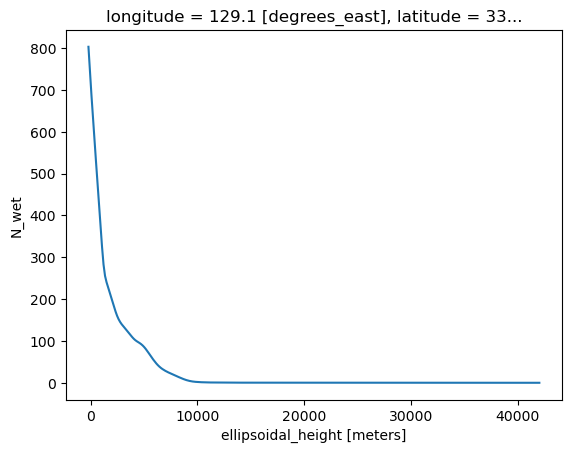

In [7]:
ds['N_wet'].isel(time = 0, longitude = 0, latitude = 0).plot()

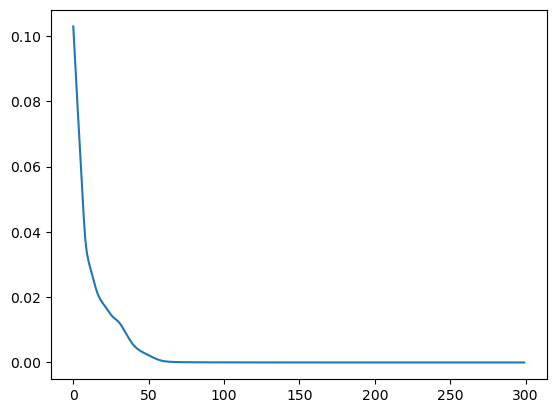

In [8]:
plt.plot(wet[0,0])

In [10]:
from pyaps3.era import get_ecmwf
lvls,latlist,lonlist,gph,tmp,vpr,humid = get_ecmwf(obj1.model, obj1.gfile, obj1.minlat, obj1.maxlat, obj1.minlon, obj1.maxlon, obj1.dict, extra= True)

3:Specific humidity:kg kg**-1 (instant):regular_ll:isobaricInhPa:level 1:fcst time 0 hrs:from 201010171400
6:Specific humidity:kg kg**-1 (instant):regular_ll:isobaricInhPa:level 2:fcst time 0 hrs:from 201010171400
9:Specific humidity:kg kg**-1 (instant):regular_ll:isobaricInhPa:level 3:fcst time 0 hrs:from 201010171400
12:Specific humidity:kg kg**-1 (instant):regular_ll:isobaricInhPa:level 5:fcst time 0 hrs:from 201010171400
15:Specific humidity:kg kg**-1 (instant):regular_ll:isobaricInhPa:level 7:fcst time 0 hrs:from 201010171400
18:Specific humidity:kg kg**-1 (instant):regular_ll:isobaricInhPa:level 10:fcst time 0 hrs:from 201010171400
21:Specific humidity:kg kg**-1 (instant):regular_ll:isobaricInhPa:level 20:fcst time 0 hrs:from 201010171400
24:Specific humidity:kg kg**-1 (instant):regular_ll:isobaricInhPa:level 30:fcst time 0 hrs:from 201010171400
27:Specific humidity:kg kg**-1 (instant):regular_ll:isobaricInhPa:level 50:fcst time 0 hrs:from 201010171400
30:Specific humidity:kg kg*

In [11]:
q = xr.DataArray(humid.reshape(*latlist.shape, *lvls.shape), coords = [latlist[:,0], lonlist[0, :], lvls], dims = ['latitude', 'longitude','level']).to_dataset(name = 'q')

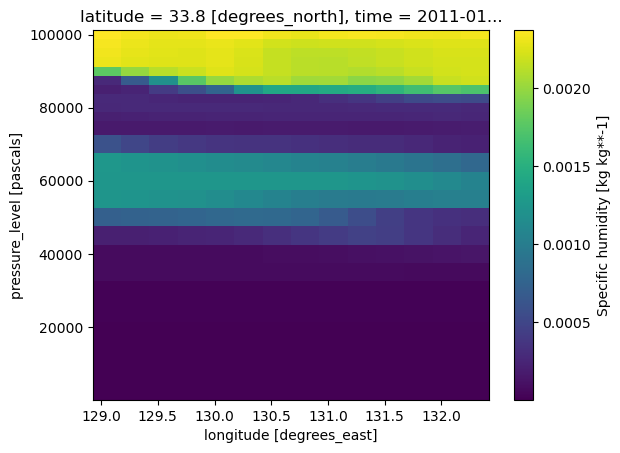

In [12]:
era.sel(latitude = q.isel(latitude = 0).latitude, method='nearest')['q'].plot()

In [13]:
q.transpose()['q'].isel(latitude = 0, ).data #() #get_vapor_partial_pressure(q)

array([[3.75399850e-06, 3.73483363e-06, 3.74113461e-06, 3.74627143e-06,
        3.74228421e-06, 3.74435058e-06, 3.47330297e-06, 3.51125436e-06,
        3.48951380e-06, 3.45808166e-06, 3.45045646e-06, 3.43326337e-06,
        3.45110402e-06],
       [3.75190302e-06, 3.73471721e-06, 3.74183310e-06, 3.74804677e-06,
        3.74554384e-06, 3.74756655e-06, 3.47341938e-06, 3.49222046e-06,
        3.48738922e-06, 3.45601529e-06, 3.44830278e-06, 3.43725060e-06,
        3.45287935e-06],
       [3.74950196e-06, 3.74107640e-06, 3.74283718e-06, 3.75014224e-06,
        3.74877436e-06, 3.75073887e-06, 3.47496189e-06, 3.49498532e-06,
        3.48561389e-06, 3.45394892e-06, 3.44600357e-06, 3.44179080e-06,
        3.45471290e-06],
       [3.74782849e-06, 3.74109095e-06, 3.74387037e-06, 3.75223772e-06,
        3.75207765e-06, 3.75392574e-06, 3.47577679e-06, 3.49777929e-06,
        3.49312268e-06, 3.45196986e-06, 3.44364616e-06, 3.44595264e-06,
        3.45666285e-06],
       [3.74605315e-06, 3.74104729e-

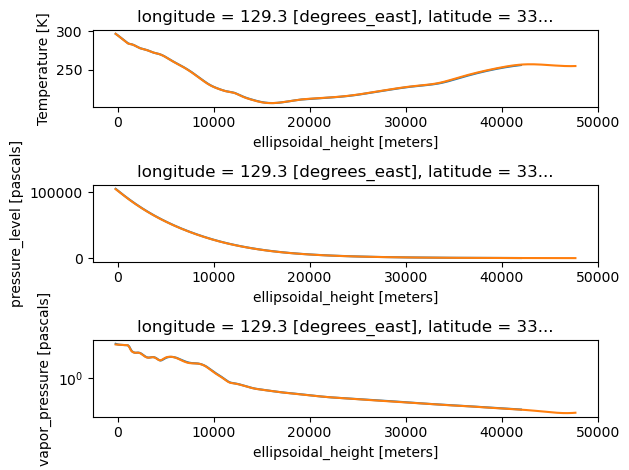

In [15]:
fig, axes = plt.subplots(3)
lat_i = 0
lon_i = 0

ax = axes[0]
ds['temperature'].isel(time = 0).sel(latitude= obj1.latlist[lat_i,0], longitude = obj1.lonlist[0,lon_i], method = 'nearest').plot(ax = ax)
ax.plot(obj1.hgt, obj1.Ti[lat_i,lon_i])

ax = axes[1]
ds['air_pressure'].isel(time = 0).sel(latitude= obj1.latlist[lat_i,0], longitude = obj1.lonlist[0,lon_i], method = 'nearest').plot(ax = ax)
ax.plot(obj1.hgt, obj1.Pi[lat_i,lon_i])

ax = axes[2]
ds['vapor_pressure'].isel(time = 0).sel(latitude= obj1.latlist[lat_i,0], longitude = obj1.lonlist[0,lon_i], method = 'nearest').plot(ax = ax)
ax.plot(obj1.hgt, obj1.Vi[lat_i,lon_i])

plt.yscale('log')

plt.tight_layout()